# 5B Agent实际生产环境部署

## 5B.1 生产环境概述

容器化部署是现代软件开发中的一种重要实践，尤其是在涉及多个组件和服务的复杂系统中。通过容器化，可以确保应用程序在不同环境中具有一致的运行状态，从而简化部署和管理过程。在本节中，我们将介绍如何将我们之前构建的Agent系统进行容器化部署。

由于本节内容较为复杂，建议选择本project的同学具备一定的基础技术。本教程需要使用WSL2，所以只保证在Windows教育版、专业版和企业版上可以正常运行。

建议可以先尝试5A的project动手做一个Agent，学有余力的同学可以进行本节的生产环境部署。

## 5B.2 WSL

## 5B.3 Docker

## 5B.3 Docker

### 5B.3.1 安装Docker

Docker安装文档：https://docs.docker.com/get-started/get-docker/

接着检查Docker的WSL集成状态，打开Docker Desktop，进入“Settings” -> “Resources” -> “WSL Integration”，确保“Enable integration with my default WSL distro”和所需发行版均已勾选。若未勾选，开启后点击“Apply & Restart”按钮应用设置并重启Docker。

### 5B.3.2 改变Docker镜像源

#### 5B.3.2.1 修改Docker Engine镜像源（首推）

1. 启动Docker Desktop，若无弹出窗口可能是已经有Docker在运行，可在任务栏点击Docker图标进入Docker Desktop
2. 点击 Docker Desktop 右上角的「设置」（齿轮图标）
3. 左侧选择「Docker Engine」
4. 在「Daemon」配置文件中，找到 `"registry-mirrors": []`，复制粘贴以下内容：
    ```json
    {
    "registry-mirrors": [
        "https://hub-mirror.c.163.com", 
        "https://mirror.aliyuncs.com", 
        "https://docker.mirrors.ustc.edu.cn"
    ]
    }
    ```

#### 5B.3.2.2 并非联动Docker Desktop的WSL发行版更改镜像源（罕见）

上一种方法仅适用于Windows端Docker Desktop联动WSL发行版的情况，若仍然无法拉取镜像，可以尝试以下方法：

首先运行并配置WSL环境，可在开始菜单中搜索Ubuntu并打开，在对话框中逐行运行以下命令以进入镜像源编辑页：
```bash
sudo mkdir -p /etc/docker
sudo nano /etc/docker/daemon.json
```

复制粘贴以下内容：
```json
{
  "registry-mirrors": [
    "https://hub-mirror.c.163.com",        // 网易镜像源（稳定）
    "https://mirror.aliyuncs.com",         // 阿里云镜像源（推荐）
    "https://docker.mirrors.ustc.edu.cn"   // 中科大镜像源（备用）
  ]
}
```

界面如下：
![Captura de pantalla 2025-12-08 235744.png](<attachment:Captura de pantalla 2025-12-08 235744.png>)

保存并退出：按 `Ctrl + O` 保存，按 `Enter` 确认文件名，按 `Ctrl + X` 退出编辑器。

最后，重启Docker服务：
```bash
sudo systemctl daemon-reload
sudo systemctl restart docker

docker info | grep "Registry Mirrors"
```
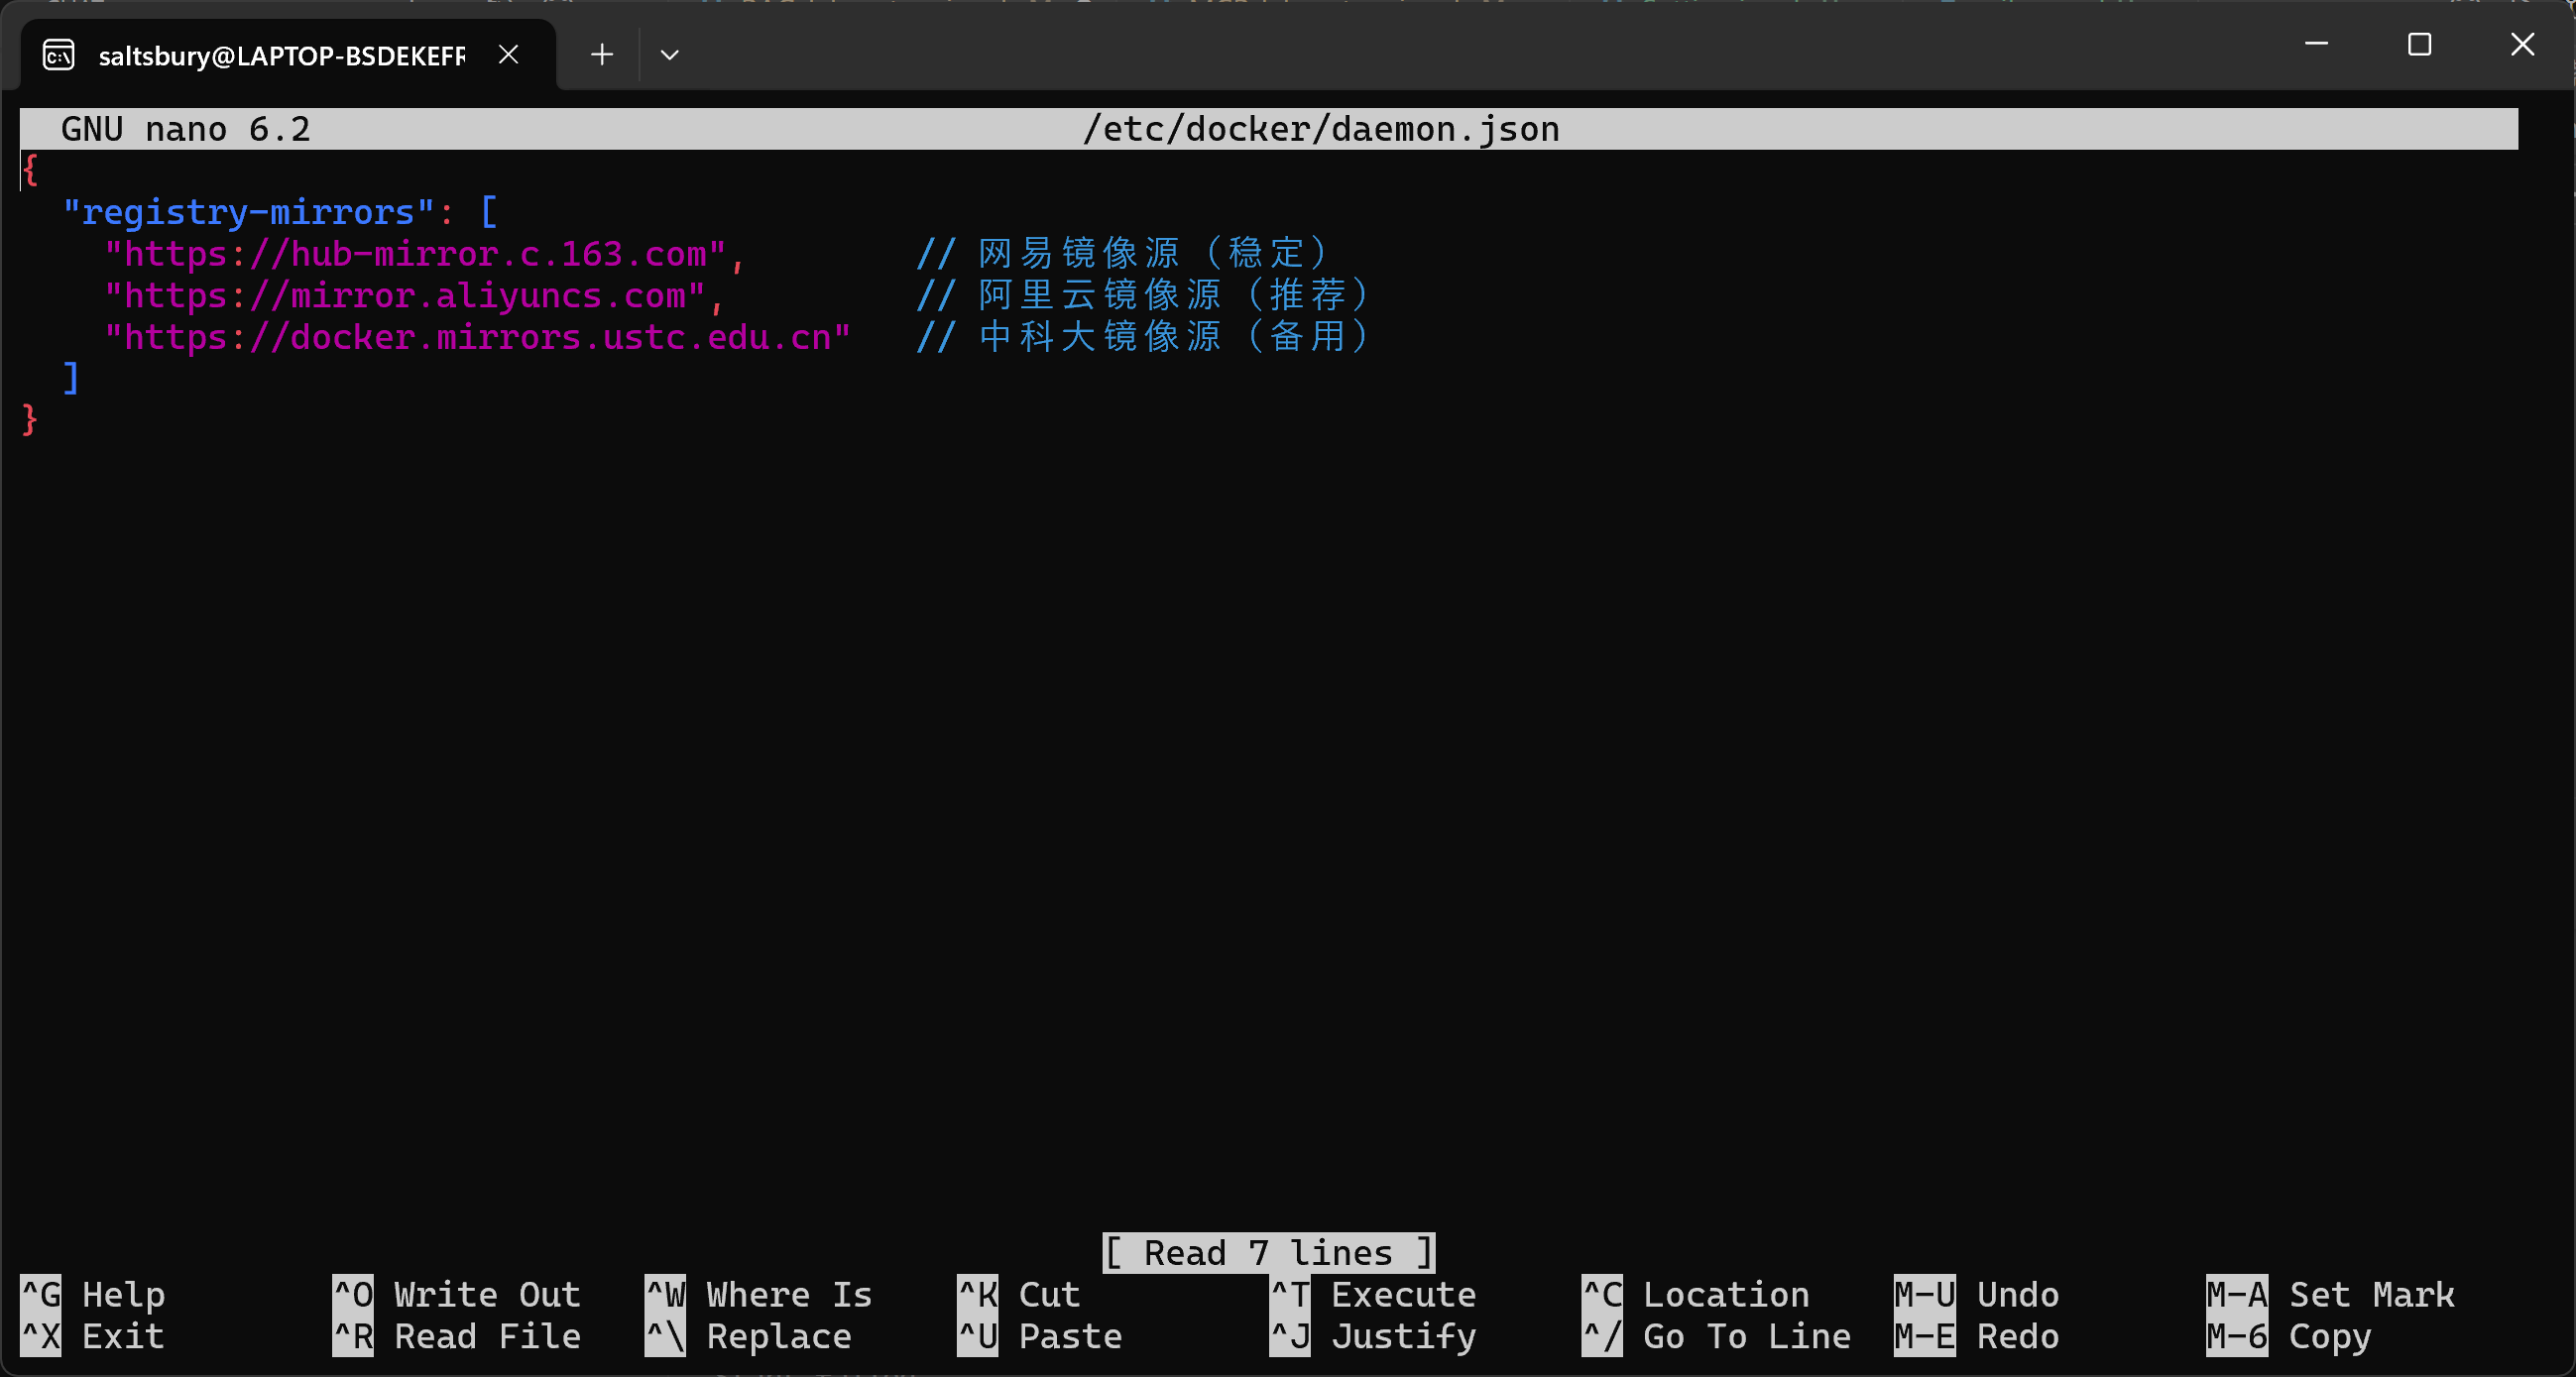

## 5B.4 Milvus容器化部署

### 5B.4.1 在Docker容器中安装Milvus

官方文档：https://milvus.io/docs/zh/install_standalone-docker.md

#### 5B.4.1.1 检查Docker配置

在Windows系统中，Docker依赖于WSL2。

1. 首先检查WSL状态，在命令行中执行 `wsl -l -v`，若输出为 `Running` 则说明WSL配置正常：
    ```bash
    wsl -l -v
    ```

2. 接着检查Docker状态，在命令行中直行 `docker info`，若能正确输出Docker信息则说明Docker配置正常：
    ```bash
    docker info
    ```

3. 将Docker和WSL连接起来，打开Docker Desktop，依次点击 `Settings` -> `Resources` -> `WSL Integration`，开启 `Enable integration with my default WSL distro` 选项，点击 `Apply & Restart` 按钮。

    如下图，将Ubuntu前的开关打开，并点击右下角的`Apply and Restart`即可（若未找到发行版，可点击下方的`Refetch distros`）
    ![Captura de pantalla 2025-12-08 235303.png](<attachment:Captura de pantalla 2025-12-08 235303.png>)
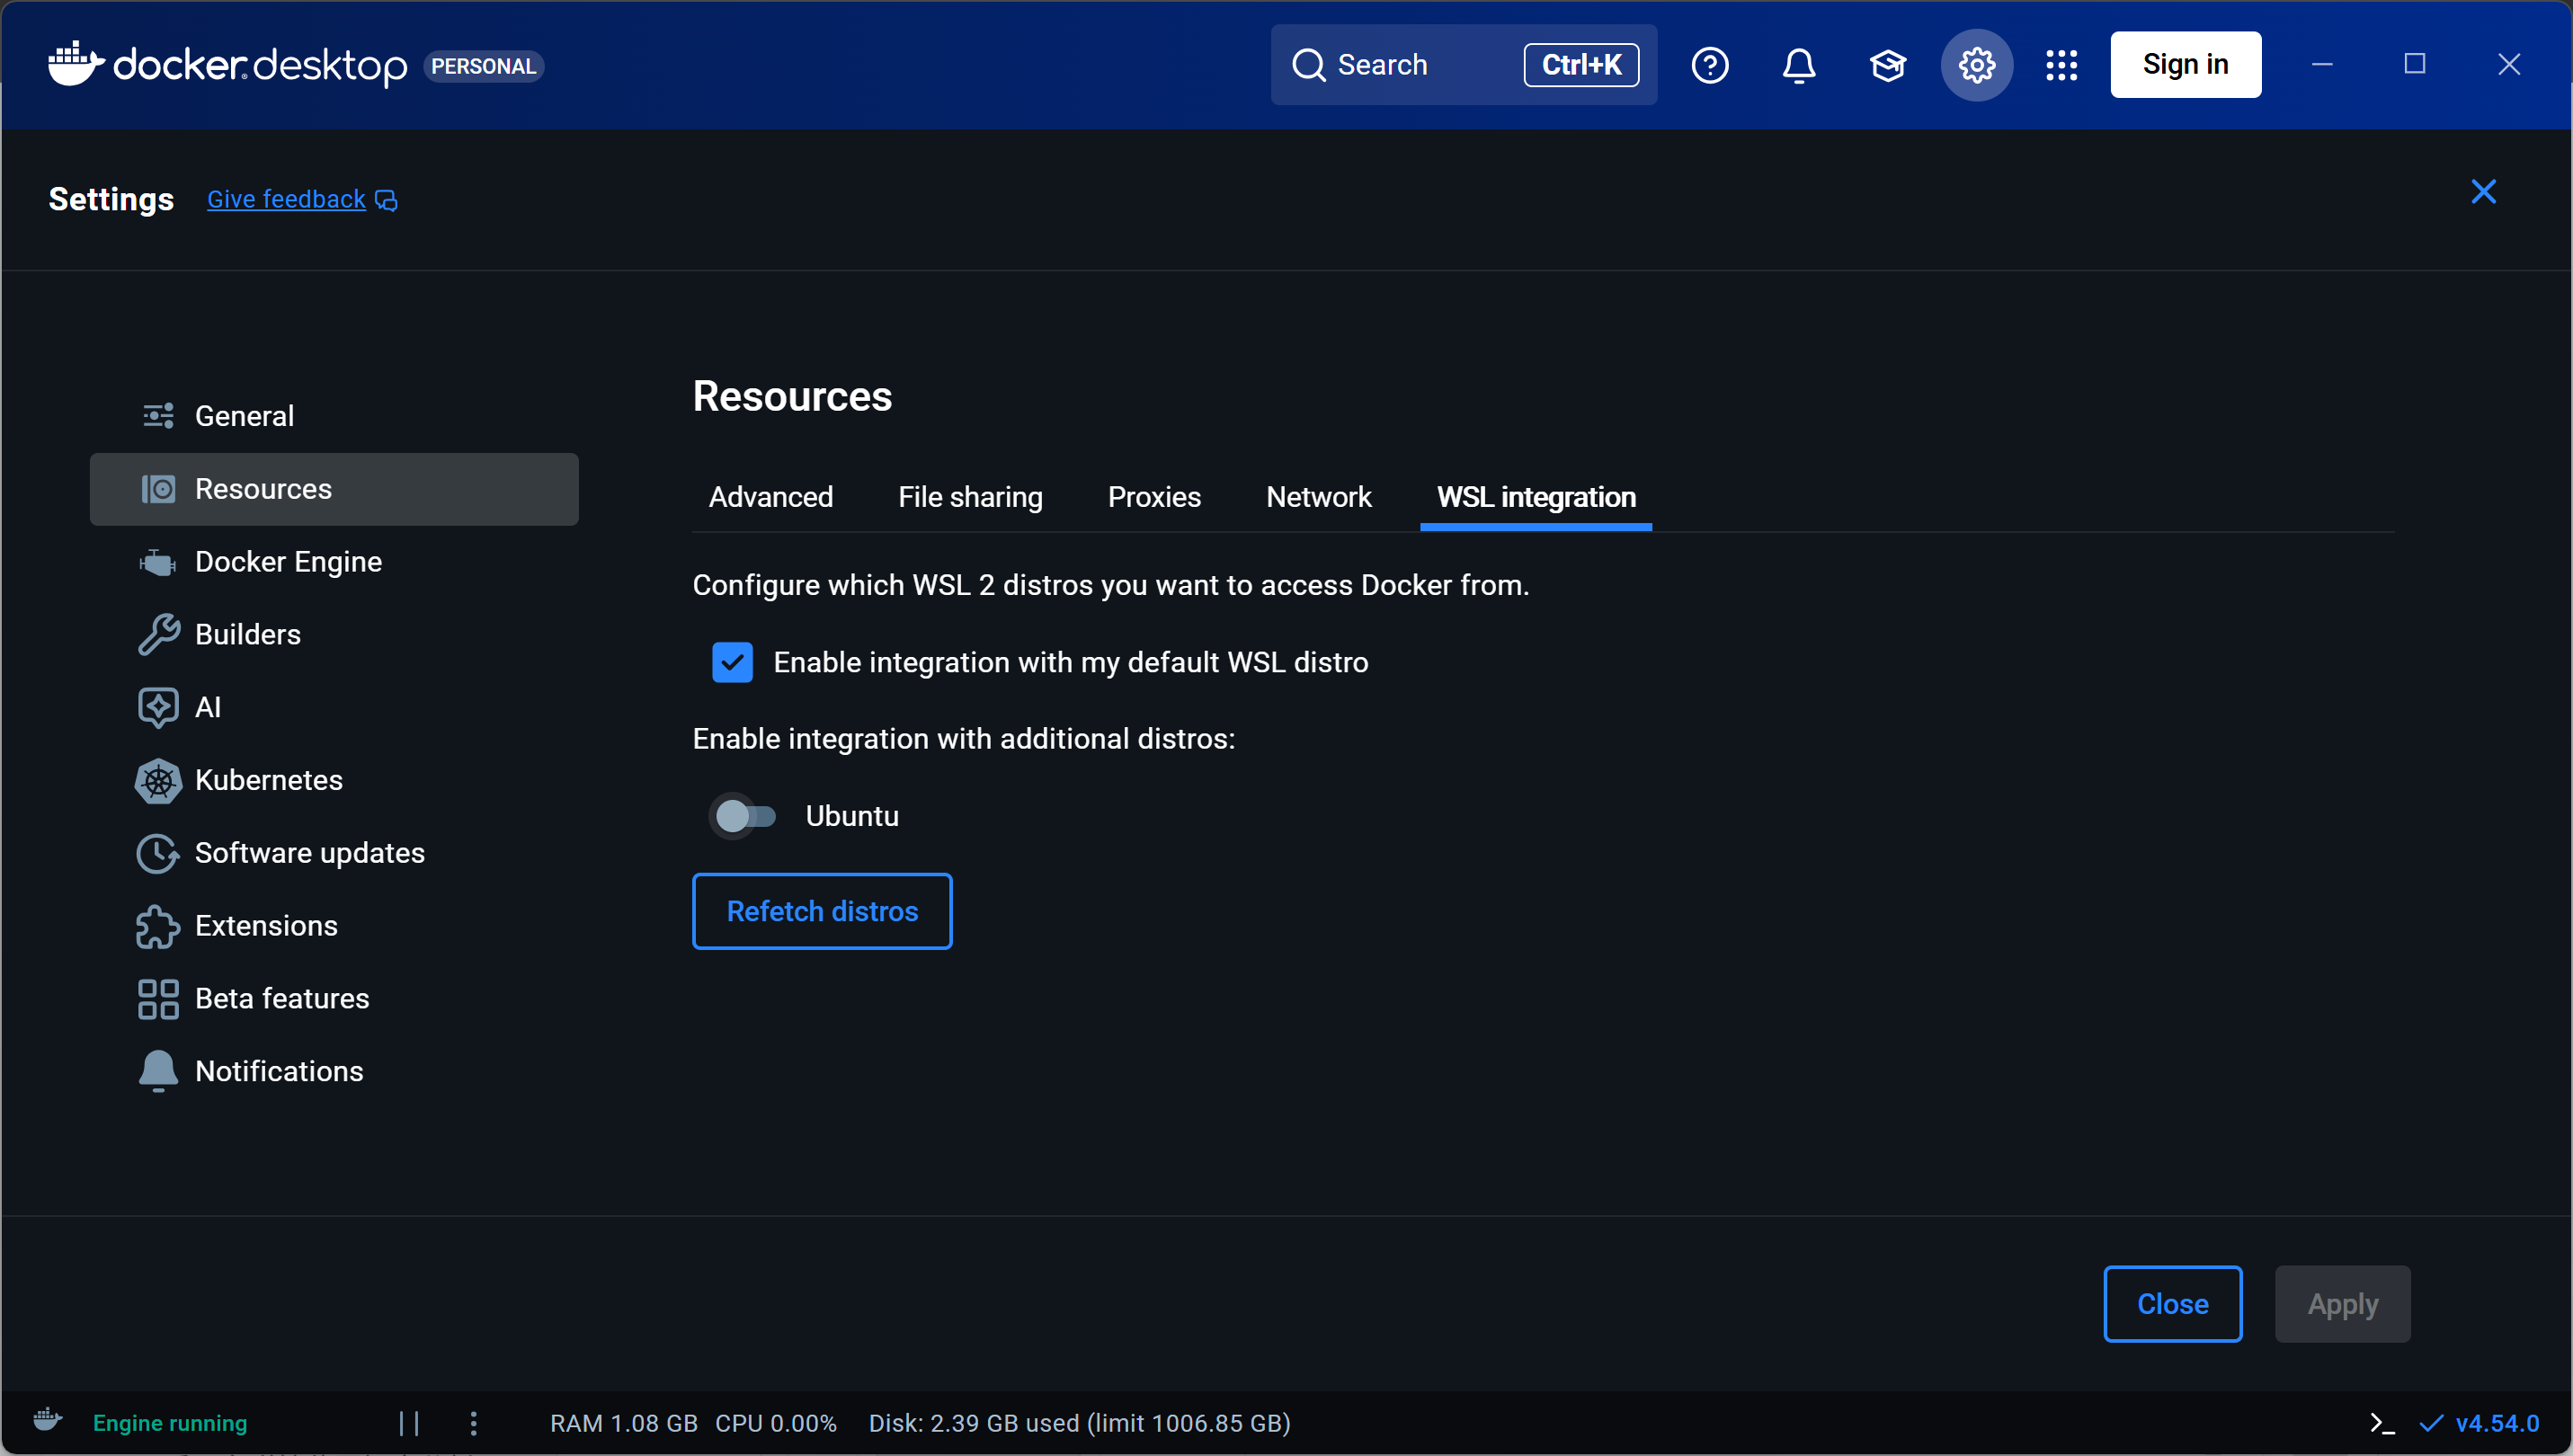

#### 5B.4.1.2 将Milvus安装为单独的Docker容器

下面仍然提供两种方式：快速部署（5B.4.1.2.1）和自定义部署（5B.4.1.2.2）。注意，每个Milvus都是一个独立的Docker容器，因此在已有环境Milvus数据库的情况下，需要使用自定义部署并修改端口号以避免冲突。

##### 5B.4.1.2.1 快速部署：部署第一个Milvus容器

确保已经更换Docker镜像源（否则请进入5B.3.2节），打开新的终端页面，运行以下命令以安装Milvus：

```bash
curl -sfL https://raw.githubusercontent.com/milvus-io/milvus/master/scripts/standalone_embed.sh -o standalone_embed.sh
bash standalone_embed.sh start
```

常见报错：
1. Docker未运行

    ```
    sudo: docker: command not found
    sudo: docker: command not found
    sudo: docker: command not found
    Start failed.
    ```

    解决方法：启动Docker Desktop（确保 Docker 处于运行状态，任务栏有 Docker 图标）；

2. 无法拉取镜像

    ```
    Unable to find image 'milvusdb/milvus:v2.6.7' locally
    docker: Error response from daemon: Get "https://registry-1.docker.io/v2/": EOF

    Run 'docker run --help' for more information
    Start failed.
    ```

    解决方法：https://mirror.ccs.tencentyun.com/milvusdb/milvus:v2.6.7

在WSL中安装需要输入密码，安装完成后会自动启动Milvus容器。

##### 5B.4.1.2.2 自定义部署：使用Docker Compose部署Milvus容器

自定义部署也可以通过修改下载的 `standalone_embed.sh` 脚本中的Docker Compose配置文件，然后运行 `standalone_embed.sh` 脚本来启动Milvus容器。这样同样可以自定义Milvus容器的部署参数，例如端口号、数据存储路径等。但由于不如Docker Compose文件直观，建议有需要时参考Milvus官方文档进行修改。

### 5B.4.2 验证Milvus配置

创建`1_basic_rag/vector_db_setup.py`

In [ ]:
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.vector_stores.milvus import MilvusVectorStore
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import pickle
from datetime import datetime

def build_rag_index(
    nodes_path: str = "processed_nodes.pkl",
    collection_name: str = "basic_rag_collection",
    overwrite: bool = True
):
    """
    构建RAG系统索引（LLM课程向量应用的进阶实现）
    """
    # 1. 加载预处理文档
    print(f"从 {nodes_path} 加载文档块...")
    with open(nodes_path, "rb") as f:
        nodes = pickle.load(f)
    print(f"加载完成，共 {len(nodes)} 个文档块")
    
    # 2. 初始化嵌入模型（扩展LLM课程的模型应用）
    print("初始化嵌入模型...")
    embed_model = HuggingFaceEmbedding(
        model_name="BAAI/bge-base-en-v1.5",
        embed_batch_size=16
    )
    
    # 3. 配置Milvus向量存储（RAG特有技术点）
    print(f"连接Milvus向量数据库，集合名称: {collection_name}")
    vector_store = MilvusVectorStore(
        uri="./milvus_rag.db",  # 本地文件存储
        collection_name=collection_name,
        dim=768,  # BGE模型输出维度
        overwrite=overwrite,
        similarity_metric="COSINE",
        index_config={
            "index_type": "HNSW",  # 高效近似最近邻索引
            "params": {"M": 16, "efConstruction": 256}
        }
    )
    
    # 4. 创建索引
    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    index = VectorStoreIndex.from_documents(
        nodes,
        storage_context=storage_context,
        embed_model=embed_model
    )
    
    print("RAG索引构建完成")
    return index

def create_query_engine(index):
    """创建查询引擎（继承LLM课程的查询设计）"""
    query_engine = index.as_query_engine(
        similarity_top_k=5,  # 返回前5个相关文档
        streaming=False
    )
    return query_engine

if __name__ == "__main__":
    index = build_rag_index()
    
    # 创建查询引擎
    query_engine = create_query_engine(index)
    
    # 测试查询（使用LLM课程相同的测试案例，便于对比）
    test_queries = [
        "企业去年的营收是多少？",
        "产品的核心功能有哪些？",
        "营销策略包含哪些渠道？"
    ]
    
    print("\n===== 测试RAG系统 =====对比LLM直出结果====")
    for query in test_queries:
        print(f"查询: {query}")
        response = query_engine.query(query)
        print(f"RAG增强回答: {str(response)[:200]}...\n")
    
    # 保存索引配置
    index.storage_context.persist(persist_dir="rag_index_storage")
    print("索引配置已保存至 rag_index_storage 目录")

### 2.2.2 向量数据库集成

In [ ]:
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.vector_stores.milvus import MilvusVectorStore
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.embeddings import SparseEmbedding
from typing import List, Dict, Any
import os
import pickle
from rank_bm25 import BM25Okapi

# 自定义BM25稀疏嵌入函数（RAG高级技术）
class BM25SparseEmbeddingFunction:
    def __init__(self):
        self.bm25 = None
        self.tokenizer = lambda x: x.split()
        self.corpus = []
        self.vocab = set()

    def fit(self, texts: List[str]):
        """训练BM25模型"""
        self.corpus = [self.tokenizer(text) for text in texts]
        self.bm25 = BM25Okapi(self.corpus)
        # 收集词汇表
        for doc in self.corpus:
            self.vocab.update(doc)
        return self

    def __call__(self, text: str) -> SparseEmbedding:
        """生成稀疏嵌入"""
        tokens = self.tokenizer(text)
        doc_scores = self.bm25.get_scores(tokens)
        
        # 创建稀疏向量（仅保留非零分数）
        indices = [i for i, score in enumerate(doc_scores) if score > 0]
        values = [float(score) for score in doc_scores if score > 0]
        
        return SparseEmbedding(indices=indices, values=values)

def build_hybrid_rag_system():
    """构建混合检索RAG系统（RAG进阶内容）"""
    # 1. 加载预处理文档
    with open("processed_nodes.pkl", "rb") as f:
        nodes = pickle.load(f)
    texts = [node.text for node in nodes]
    
    # 2. 初始化嵌入模型（融合LLM与检索技术）
    dense_embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-base-en-v1.5")
    sparse_embed_model = BM25SparseEmbeddingFunction().fit(texts)
    
    # 3. 配置Milvus混合检索
    vector_store = MilvusVectorStore(
        uri="./milvus_hybrid.db",
        collection_name="hybrid_rag_collection",
        dim=768,
        overwrite=True,
        enable_sparse=True,
        sparse_embedding_function=sparse_embed_model,
        hybrid_ranker="WeightedRanker",
        hybrid_ranker_params={"weights": [0.7, 0.3]}  # 密集:稀疏 = 7:3
    )
    
    # 4. 创建索引
    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    index = VectorStoreIndex.from_documents(
        nodes,
        storage_context=storage_context,
        embed_model=dense_embed_model
    )
    
    print("混合检索RAG系统构建完成")
    return index

## 5B.5 MCP容器化部署

## 5B.6 Ollama 容器化部署